In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

import dsa
from dsa import *
from models import mlp
import pickle
from sklearn.model_selection import train_test_split

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
def make_dataset(X, Y, f):
    x = tf.data.Dataset.from_tensor_slices(X)
    y = tf.data.Dataset.from_tensor_slices(Y)
    x = x.map(f)
    xy = tf.data.Dataset.zip((x, y))
    xy = xy.shuffle(10000)
    return xy

df = pd.read_excel('../datasets/credit-card.xls', header=1, index_col=0).sample(frac=1)
x = df.drop(columns=["default payment next month"]).to_numpy()
x = (x - np.min(x, axis=0))/(np.max(x, axis=0) - np.min(x, axis=0))
y = df["default payment next month"].to_numpy().reshape((len(x), 1)).astype("float32")

aux_target_ratio = 0.2

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=aux_target_ratio/(aux_target_ratio+1), random_state=42)

target_ds = make_dataset(x_train, y_train, lambda t: t)
aux_ds = make_dataset(x_test, y_test, lambda t: t)

2022-03-31 14:00:20.754049: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-31 14:00:20.754134: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: xgpd0
2022-03-31 14:00:20.754149: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: xgpd0
2022-03-31 14:00:20.754371: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.103.1
2022-03-31 14:00:20.754424: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-03-31 14:00:20.754436: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.103.1
2022-03-31 14:00:20.754968: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in per

In [4]:
credit_dsa = {}
log_credit_dsa = {}

for split in [2,3,4]:
    make_f, make_g, make_e, make_d, make_c = mlp.make_mlp(attr_num=23, class_num=2, split=split, units=64, ed_act="sigmoid")
    credit_dsa[split] = dsa(target_ds=target_ds, aux_ds=aux_ds)
    print("============================")
    print("======Split level is {}======".format(split))
    print("============================")
    log_credit_dsa[split] = credit_dsa[split].dsa_attack(
        make_f=make_f,
        make_g=make_g,
        lr=0.001,
        loss_fn=tf.keras.losses.BinaryCrossentropy(),
        acc_fn=tf.keras.metrics.BinaryAccuracy(),
        batch_size=32,
        iterations=1000,
        make_e=make_e,
        make_d=make_d,
        make_c=make_c,
        lr_e=0.001, # learning rate of the encoder/decoder/critic is set to be smaller
        lr_d=0.001,
        lr_c=0.001,
        verbose=True,
        log_freq=200)

======Split level is 2======
Iteration 200, train accuracy: 0.7553232429921627, average attack MSE: 0.027985462443903087
Iteration 400, train accuracy: 0.7910721826553345, average attack MSE: 0.01923666661605239
Iteration 600, train accuracy: 0.7979757365584373, average attack MSE: 0.01905485006980598
Iteration 800, train accuracy: 0.8032020136713982, average attack MSE: 0.018905141931027172
Iteration 1000, train accuracy: 0.8067747697234153, average attack MSE: 0.018882954083383082
======Split level is 3======
Iteration 200, train accuracy: 0.7819424962997437, average attack MSE: 0.03010203307494521
Iteration 400, train accuracy: 0.7937944000959396, average attack MSE: 0.019115262529812754
Iteration 600, train accuracy: 0.7991245818138123, average attack MSE: 0.019019246762618423
Iteration 800, train accuracy: 0.8022598525881768, average attack MSE: 0.01882266087923199
Iteration 1000, train accuracy: 0.8057249701023101, average attack MSE: 0.018889740072190762
======Split level is 4==

In [5]:
from fsha import *

credit_fsha={}
log_credit_fsha={}

for split in [4,3,2]:
    print("============================")
    print("======Split level is {}======".format(split))
    print("============================")
    hparams = {
        'WGAN' : False,
        'style_loss' : None,
        'lr_f' :  0.001,
        'lr_tilde': 0.001,
        'lr_D': 0.001,
        'lr_g': 0.001
    }
    make_f, make_g, make_e, make_d, make_c = mlp.make_mlp(attr_num=23, class_num=2, split=split, units=64, ed_act="sigmoid")
    models = (make_f, make_g, make_e, make_d, make_c)
    credit_fsha[split] = FSHA(
        target_ds, aux_ds,
        loss_fn=tf.keras.losses.BinaryCrossentropy(),
        acc_fn=tf.keras.metrics.BinaryAccuracy(), models=models, batch_size=32, hparams=hparams)
    log_credit_fsha[split]=credit_fsha[split](1000, verbose=True, progress_bar=False, log_frequency=200)

======Split level is 4======
RUNNING...
Iteration 0000000 train accuracy: 0.1875, validation: 0.1888
Iteration 0000200 train accuracy: 0.5841, validation: 0.0304
Iteration 0000400 train accuracy: 0.7333, validation: 0.0190
Iteration 0000600 train accuracy: 0.7523, validation: 0.0194
Iteration 0000800 train accuracy: 0.7581, validation: 0.0190
======Split level is 3======
RUNNING...
Iteration 0000000 train accuracy: 0.8750, validation: 0.1517
Iteration 0000200 train accuracy: 0.7919, validation: 0.0274
Iteration 0000400 train accuracy: 0.7825, validation: 0.0191
Iteration 0000600 train accuracy: 0.7790, validation: 0.0190
Iteration 0000800 train accuracy: 0.7774, validation: 0.0191
======Split level is 2======
RUNNING...
Iteration 0000000 train accuracy: 0.6875, validation: 0.1544
Iteration 0000200 train accuracy: 0.7788, validation: 0.0281
Iteration 0000400 train accuracy: 0.7779, validation: 0.0189
Iteration 0000600 train accuracy: 0.7778, validation: 0.0191
Iteration 0000800 train ac

In [6]:
with open('log/credit-dsa.pkl', 'wb') as f:
    pickle.dump(log_credit_dsa, f)
with open('log/credit-fsha.pkl', 'wb') as f:
    pickle.dump(log_credit_fsha, f)

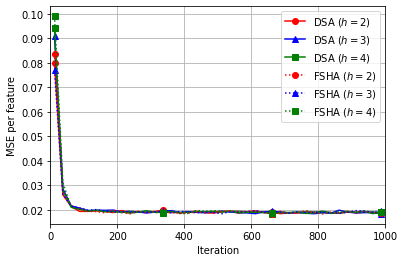

In [10]:
from matplotlib.pyplot import figure
# figure(figsize=(6.4,4.8))
log_freq = 25
# plt.yscale('logit')
plt.xlim([0,1000])
plt.grid()

sampled_loss = {}
sampled_fsha_loss = {}

for split in [2,3,4]:
    sampled_loss[split] = [sum(log_credit_dsa[split][:,2][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log_credit_dsa[split][:,0])/log_freq))]
    sampled_fsha_loss[split] = [sum(log_credit_fsha[split][:,2][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log_credit_fsha[split][:,0])/log_freq))]
ran = [i * log_freq + log_freq/2 for i in range(int(1000/log_freq))]
plt.ylabel('MSE per feature')
plt.xlabel('Iteration')
plt.plot(ran, sampled_loss[2], 'ro-', ran, sampled_loss[3], 'b^-', ran, sampled_loss[4], 'gs-', markevery=13)
plt.plot(ran, sampled_fsha_loss[2], 'ro:', ran, sampled_fsha_loss[3], 'b^:', ran, sampled_fsha_loss[4], 'gs:', markevery=13)
# ax2=plt.gca().twinx()
# ax2.plot(ran, sampled_acc[2], 'ro-', ran, sampled_acc[3], 'b^-', ran, sampled_acc[4], 'gs-', markevery=7)
plt.legend(["DSA ($h=2$)", "DSA ($h=3$)", "DSA ($h=4$)", "FSHA ($h=2$)", "FSHA ($h=3$)", "FSHA ($h=4$)"])
plt.savefig("fig/credit.pdf", bbox_inches='tight')

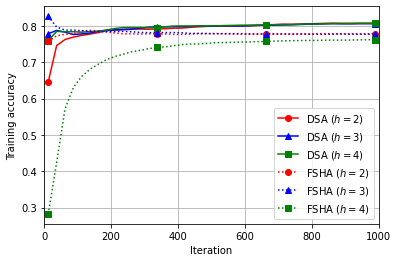

In [8]:
from matplotlib.pyplot import figure
# figure(figsize=(6.4,4.8))
log_freq = 25
# plt.yscale('logit')
plt.xlim([0,1000])
plt.grid()

sampled_acc = {}
sampled_fsha_acc = {}

for split in [2,3,4]:
    sampled_acc[split] = [sum(log_credit_dsa[split][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log_credit_dsa[split][:,0])/log_freq))]
    sampled_fsha_acc[split] = [sum(log_credit_fsha[split][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log_credit_fsha[split][:,0])/log_freq))]
ran = [i * log_freq + log_freq/2 for i in range(int(1000/log_freq))]
plt.ylabel('Training accuracy')
plt.xlabel('Iteration')
plt.plot(ran, sampled_acc[2], 'ro-', ran, sampled_acc[3], 'b^-', ran, sampled_acc[4], 'gs-', markevery=13)
plt.plot(ran, sampled_fsha_acc[2], 'ro:', ran, sampled_fsha_acc[3], 'b^:', ran, sampled_fsha_acc[4], 'gs:', markevery=13)
# ax2=plt.gca().twinx()
# ax2.plot(ran, sampled_acc[2], 'ro-', ran, sampled_acc[3], 'b^-', ran, sampled_acc[4], 'gs-', markevery=7)
plt.ylabel('Training accuracy')
plt.legend(["DSA ($h=2$)", "DSA ($h=3$)", "DSA ($h=4$)", "FSHA ($h=2$)", "FSHA ($h=3$)", "FSHA ($h=4$)"])
plt.savefig("fig/credit-acc.pdf", bbox_inches='tight')

In [24]:
split=4
credit_dsa_size = {}
log_credit_dsa_size = {}

make_f, make_g, make_e, make_d, make_c = mlp.make_mlp(attr_num=23, class_num=2, split=split, units=64, ed_act="sigmoid")

for size in [1,5,10,20,50]:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=size, random_state=42)
    
    target_ds = make_dataset(x_train, y_train, lambda t: t)
    aux_ds = make_dataset(x_test, y_test, lambda t: t)
    
    credit_dsa_size[size] = dsa(target_ds=target_ds, aux_ds=aux_ds)
    print("============================")
    print("======Auxiliary size is {}======".format(size))
    print("============================")
    log_credit_dsa_size[size] = credit_dsa_size[size].dsa_attack(
        make_f=make_f,
        make_g=make_g,
        lr=0.001,
        loss_fn=tf.keras.losses.BinaryCrossentropy(),
        acc_fn=tf.keras.metrics.BinaryAccuracy(),
        batch_size=32,
        iterations=1000,
        make_e=make_e,
        make_d=make_d,
        make_c=make_c,
        lr_e=0.001, # learning rate of the encoder/decoder/critic is set to be smaller
        lr_d=0.001,
        lr_c=0.001,
        verbose=True,
        log_freq=200)

======Auxiliary size is 1======
Iteration 200, train accuracy: 0.7549350482225418, average attack MSE: 0.0397772925067693
Iteration 400, train accuracy: 0.7915664768218994, average attack MSE: 0.03337196351960301
Iteration 600, train accuracy: 0.7999402549862862, average attack MSE: 0.03275146482512355
Iteration 800, train accuracy: 0.803431940972805, average attack MSE: 0.03324496265500784
Iteration 1000, train accuracy: 0.8052429327368736, average attack MSE: 0.03339803640730679
======Auxiliary size is 5======
Iteration 200, train accuracy: 0.780677140057087, average attack MSE: 0.03313291104510427
Iteration 400, train accuracy: 0.7962543547153473, average attack MSE: 0.026090823458507658
Iteration 600, train accuracy: 0.8016059684753418, average attack MSE: 0.02633149699307978
Iteration 800, train accuracy: 0.8052545002102852, average attack MSE: 0.026142604229971767
Iteration 1000, train accuracy: 0.8067840376496315, average attack MSE: 0.026175690023228525
======Auxiliary size is 

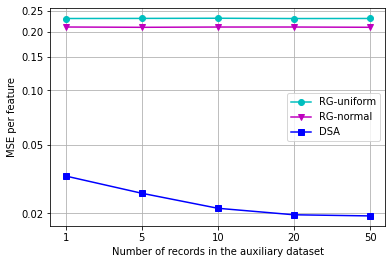

In [84]:
ran = ["1","5","10","20","50"]
rgn = [tf.keras.losses.MeanSquaredError()(np.random.normal(loc=0.5,scale=0.25,size=x.shape),x) for i in ran]
rgu = [tf.keras.losses.MeanSquaredError()(np.random.uniform(low=0,high=1,size=x.shape),x) for i in ran]
mse = [0.033,0.0262,0.0214,0.0196,0.0193]
plt.yscale('logit')
plt.grid()
plt.yticks(ticks=[0.02,0.05,0.1,0.15,0.2,0.25],labels=["0.02","0.05","0.10","0.15","0.20","0.25"])
plt.plot(ran,rgu,'co-',ran,rgn,'mv-',ran,mse,'bs-', markevery=1)
plt.ylabel('MSE per feature')
plt.xlabel('Number of records in the auxiliary dataset')
plt.legend(["RG-uniform", "RG-normal", "DSA"])
plt.savefig("fig/credit-size.pdf", bbox_inches='tight')